# ML Pipelines with MLJ

## Required packages

In [133]:
using DataFrames
using DataFramesMeta
using Distributions
using Random
using Gadfly
using Pipe
using MLJ

As well as the packages imported above, we also need to install:
- `MLJScikitLearnInterface` to load the SVM classifier
- `BetaML` to load the Random Forest classifier
- `MLJFlux` to load the Neural Network classifier

To install these packages, open the Package Manager menu by typing `]`, type `add MLJScikitLearnInterface`, hit enter, continue for all packages

## Motivation
Most data science pipelines involve building analysis pipelines, which allow us to run the following steps efficiently:
1. Load data and create train-test split
2. Preprocess data e.g. one-hot encode categorical features
3. Fit model to the train set
4. Evaluate model fit on the test set

In Julia, the `MLJ` package provides the individual functions that will make up the pipeline, and we can use the `Pipes` package to string them together into a single pipeline. This is similar to the individual functions in the Python `sklearn` package, and the `Pipeline` object from `sklearn`. 

## Data
To compare the performance of different models on datasets of increasing complexity, we will create some dummy datasets. Julia does not have an equivalent to the convenience functions provided by `sklearn` for simulating data (e.g. `make_blobs`, `make_gaussian_quantiles`), so we will define our own function:

In [38]:
function make_two_groups(n_samples, cluster_std, random_seed)
    Random.seed!(random_seed)
    samples_per_cluster = trunc(Int, n_samples / 2)
    group1 = DataFrame(
        group = "1",
        x = rand(Normal(1, cluster_std), samples_per_cluster),
        y = rand(Normal(1, cluster_std), samples_per_cluster)
    )
    group2 = DataFrame(
        group = "2",
        x = rand(Normal(2, cluster_std), samples_per_cluster),
        y = rand(Normal(2, cluster_std), samples_per_cluster)
    )
    groups_df = vcat(group1, group2)
    groups_df
end

make_two_groups (generic function with 1 method)

We can use this function to create two datasets, each with 2 groups with 500 points each (1,000 points in total):
1. Easy = no overlap between the groups (achieved through setting the standard deviation to 0.1) 
2. Hard = some overlap between the groups (achieved through setting the standard deviation to 0.5)

In [58]:
easy_data = make_two_groups(1000, 0.1, 13)
hard_data = make_two_groups(1000, 0.5, 13)
println("Dummy datasets created")

Dummy datasets created

If we plot the data, we can see that the two groups are clearly separate:

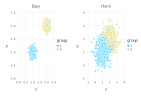

In [62]:
easy_data_plot = plot(easy_data, x=:x, y=:y, Geom.point, color=:group, alpha=[0.5], Guide.title("Easy"))
hard_data_plot = plot(hard_data, x=:x, y=:y, Geom.point, color=:group, alpha=[0.5], Guide.title("Hard"))
hstack(easy_data_plot, hard_data_plot)

## `scitypes`: how data is interpreted
In Julia, there are two different types that an object can have:
1. `machine type`: how the values are represented in memory. One of the base Julia types e.g. `Float64`
2. `scientific type`: how the values are interpreted by a Julia object or function e.g. a MLJ model. One of the types from [`ScientificType.jl`](https://github.com/JuliaAI/ScientificTypesBase.jl) e.g. `Continuous`

For example, an integer has different machine types and scientific types:

In [94]:
println(typeof(5))
println(scitype(5))

Int64
Count


It's important to know which `scitypes` are found in the data before it goes into the pipeline, because some MLJ functions will throw an error if the data isn't in a valid `scitype` and other functions may silently change the data into a `scitype`, causing unexpected behaviour. We can use the `scitype()` function to check the `scitype` of all values in an array:

In [95]:
println(scitype([5,5,5]))

AbstractVector{Count}


To return the scientific types of every column in a DataFrame, we can use the `schema()` function. To make the output easier to look at and work with, we will pipe it to a DataFrame:

In [97]:
schema(easy_data) |> DataFrame

3×3 DataFrame
 Row │ names   scitypes    types    
     │ Symbol  DataType    DataType 
─────┼──────────────────────────────
   1 │ group   Textual     String
   2 │ x       Continuous  Float64
   3 │ y       Continuous  Float64

To change the scientific type of a column, we can use the `coerce()` function. This takes the dataframe as its first argument, and the column name & `scitype` key-value pair as its second value. For example, we can coerce a column of strings which is a `Textual` scientific type into a column of categorical values which is a `Multiclass` scientific type:

In [122]:
test = DataFrame(
    name = ["Sue", "Ahmed", "Bob"],
    rating = ["Good", "Average", "Bad"]
)
println("Scitypes before coercion:")
println(schema(test) |> DataFrame)
coerce!(test, :rating => Multiclass)
println("Scitypes after coercion:")
println(schema(test) |> DataFrame)

Scitypes before coercion:
2×3 DataFrame
 Row │ names   scitypes  types    
     │ Symbol  DataType  DataType 
─────┼────────────────────────────
   1 │ name    Textual   String
   2 │ rating  Textual   String
Scitypes after coercion:
2×3 DataFrame
 Row │ names   scitypes       types                            
     │ Symbol  DataType       DataType                         
─────┼─────────────────────────────────────────────────────────
   1 │ name    Textual        String
   2 │ rating  Multiclass{3}  CategoricalValue{String, UInt32}


## Train-Test Split
Now that we have the complete dataset, we will split it into train and test sets. To do this, we use the `partition()` function from `MLJ.jl`. This takes two mandatory arguments as its first and second arguments:
1. The data structure, which can be a vector, matrix, DataFrame or lots of other things
2. The proportion of the data to assign to the training set

We will also pass two optional arguments:
1. `shuffle`: whether or not to shuffle the data before splitting it up
2. `stratify`: a column to stratify the split on, which ensures that the train and test sets have the same proportions of the different values in this column

Note that we have to use the `coerce()` function to convert the group labels from integers to the Finite scitype.

In [123]:
train, test = partition(easy_data, 0.5, shuffle=true, stratify=coerce(easy_data.group, Finite))
train_1_labels = @subset(train, :group.=="1")
test_1_labels = @subset(test, :group.=="1")
println("Train set total rows = $(size(train)[1])")
println("Train set total 1 labels = $(size(train_1_labels)[1])")
println("Test set total rows = $(size(test)[1])")
println("Test set total 1 labels = $(size(test_1_labels)[1])")

Train set total rows = 500
Train set total 1 labels = 250
Test set total rows = 500
Test set total 1 labels = 250


## Label-Feature Split
Having created train and test sets, we now need to separate the labels and features in each of them. To do this, we use the `unpack()` function, which takes the following three arguments (in this order):
1. The DataFrame holding the labels and features
2. The column holding the labels
3. The columns holding the features

Note that `unpack()` returns the labels before the features, even though in the arguments we specify the features before the labels

In [128]:
y_train, X_train = unpack(train, ==(:group), !=(:group))
println("Features are returned as type $(typeof(X_train))")
println("Labels are returned as type $(typeof(y_train))")

Features are returned as type DataFrame
Labels are returned as type Vector{String}


## Model Loading
Rather than importing whole packages, we can load specific models from different packages, by using the `@load` operator. For this example, we will use:
- `LogisticClassifier` for logistic regression
- `SVMClassifier` for support vector machine
- `RandomForestClassifier` for random forest
- `NeuralNetworkClassifier` for neural network

In [137]:
LogisticClassifier = @load LogisticClassifier pkg=MLJLinearModels
SVMClassifier = @load SVMClassifier pkg=ScikitLearn
RandomForestClassifier = @load RandomForestClassifier pkg=BetaML
NeuralNetworkClassifier = @load NeuralNetworkClassifier pkg=MLJFlux

import MLJLinearModels ✔
import MLJScikitLearnInterface ✔
import BetaML ✔
import MLJFlux ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/kmlm215/.julia/packages/MLJModels/hAzAn/src/loading.jl:159
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/kmlm215/.julia/packages/MLJModels/hAzAn/src/loading.jl:159
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/kmlm215/.julia/packages/MLJModels/hAzAn/src/loading.jl:159
┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/kmlm215/.julia/packages/MLJModels/hAzAn/src/loading.jl:159


MLJFlux.NeuralNetworkClassifier